In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import chardet
from datetime import datetime
import seaborn as sns
import folium

En este notebook realizo un análisis exploratorio de los datos y un preprocesamiento de los mismos con el objetivo de determinar los problemas que presentan los archivos y lograr una base para las funciones que armaré para las transformaciones en el proceso de ETL.

### EXTRACCIÓN

- Función para importar los datos

In [2]:
def importar(path):
    data = pd.DataFrame()
    with open(path, 'rb') as f:
        result = chardet.detect(f.read()) # Obtener encoding del archivo

        # IMPORTAR ARCHIVOS
        # csv
        if Path(path).suffix == '.csv': 
            data = pd.read_csv(path, encoding=result['encoding'], sep=',', engine='python', decimal='.')
        # txt
        elif Path(path).suffix == '.txt': 
            data = pd.read_table(path, encoding=result['encoding'], sep='|', engine='python')
        # json
        elif Path(path).suffix == '.json': 
            data = pd.read_json(path, encoding=result['encoding'], precise_float=True)
        # parquet
        elif Path(path).suffix == '.parquet': 
            data = pd.read_parquet(path, engine='pyarrow')
        # xlsx
        elif Path(path).suffix == '.xlsx':
            dict = pd.read_excel(path, sheet_name=None) # Diccionario donde key: nombre de hoja , values: df con valores del archivo
            lst_df = []
            for key in dict.keys():                     # Agrego los df a una lista, luego concateno todo el contenido de la lista en un df
                df= dict[key]
                lst_df.append(df)
            data = pd.concat(lst_df, axis=0)
            data.reset_index(drop=True, inplace = True)
            
    return data

In [3]:
folder_path = os.getcwd() + "\\Datasets\\" # Ruta de la carpeta donde están los archivos
file_path = glob.glob(folder_path + "*") # Lista de rutas de los archivos de precios

In [4]:
# Bucle que recorre todos los archivos de la carpeta, crea un df y lo agrega a una lista
lst_df = []

for path in file_path:
    df = importar(path)
    lst_df.append(df)

In [5]:
# Lista con los nombres de archivos
lst_keys = []
for path in file_path:
    filename = os.path.split(path)[1]
    filename_mod = filename.split('.')[0]
    lst_keys.append(filename_mod)

In [6]:
# Diccionario que contiene cada df y le asigna como key el nombre del archivo correspondiente
dicc_df={}
for e in range(len(lst_keys)):
    key = lst_keys[e]
    df = lst_df[e] 
    dicc_df[key] = df

In [7]:
dicc_df.keys()

dict_keys(['precios_semanas_20200419_20200426', 'precios_semana_20200413', 'precios_semana_20200503', 'precios_semana_20200518', 'producto', 'sucursal'])

---

## EDA y Preprocesamiento de Datos

### - Vista general de cada df

In [8]:
for key in dicc_df.keys():
    print('\n',key,'\n\n',dicc_df[key],'\n')


 precios_semanas_20200419_20200426 

           precio          sucursal_id    producto_id
0         399.00              2-1-092         2288.0
1         299.00              2-1-206         2288.0
2         399.00              2-2-241         2288.0
3       49999.00              9-1-430       205870.0
4       53999.00                9-2-4       205870.0
...          ...                  ...            ...
937447    139.99  2001-01-25 00:00:00  9569753142128
937448     34.99  2001-01-25 00:00:00  9795403001143
937449    312.50  2003-01-05 00:00:00  9990385651922
937450    312.50  2003-01-05 00:00:00  9990385651939
937451    198.90  2003-01-05 00:00:00  9990385651946

[937452 rows x 3 columns] 


 precios_semana_20200413 

         precio    producto_id sucursal_id
0        29.90  0000000001663     2-1-014
1        29.90  0000000002288     2-1-032
2        39.90  0000000002288     2-1-096
3       499.99  0000000205870     9-1-686
4       519.99  0000000205870     9-2-248
...        ... 

- #### Primeras impresiones:

'precios_semanas_20200419_20200426':

- Las columnas del df  deben ser ordenadas
- Contiene elementos con formato datatime en la columna "sucursal_id"
- Presenta elementos con estructura float en "producto_id"

'producto':

- Las columnas "categoria1, categoria2 y categoria3" parecen no tener valores. 

In [9]:
for key in dicc_df.keys():
    print(dicc_df[key].columns)

Index(['precio', 'sucursal_id', 'producto_id'], dtype='object')
Index(['precio', 'producto_id', 'sucursal_id'], dtype='object')
Index(['precio', 'producto_id', 'sucursal_id'], dtype='object')
Index(['precio', 'producto_id', 'sucursal_id'], dtype='object')
Index(['id', 'marca', 'nombre', 'presentacion', 'categoria1', 'categoria2',
       'categoria3'],
      dtype='object')
Index(['id', 'comercioId', 'banderaId', 'banderaDescripcion',
       'comercioRazonSocial', 'provincia', 'localidad', 'direccion', 'lat',
       'lng', 'sucursalNombre', 'sucursalTipo'],
      dtype='object')


### - Información sobre cada df

In [10]:
for key in dicc_df.keys():
    print(key, '\n\n', dicc_df[key].info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937452 entries, 0 to 937451
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   precio       933909 non-null  float64
 1   sucursal_id  937452 non-null  object 
 2   producto_id  923933 non-null  object 
dtypes: float64(1), object(2)
memory usage: 21.5+ MB
precios_semanas_20200419_20200426 

 None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472166 entries, 0 to 472165
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   precio       472153 non-null  float64
 1   producto_id  472151 non-null  object 
 2   sucursal_id  472151 non-null  object 
dtypes: float64(1), object(2)
memory usage: 10.8+ MB
precios_semana_20200413 

 None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397734 entries, 0 to 397733
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------   

Problemas encontrados:

- DF "precios_semana_20200503", columna 'precio':    es del tipo 'object' y no 'float' lo cual indica que puede deberse a la presencia de caracteres no numéricos.

- DF "producto", columnas = ['categoria1', 'categoria2', 'categoria3']:     presentan solo 4 registros completos de un total de 72038.

---

## - Registros Duplicados

- Detección

In [11]:
# Cantidad de registros duplicados por df
for key in dicc_df.keys():
    print(key, ':\t', dicc_df[key].duplicated().sum())

precios_semanas_20200419_20200426 :	 4218
precios_semana_20200413 :	 32
precios_semana_20200503 :	 0
precios_semana_20200518 :	 189
producto :	 0
sucursal :	 0


- Corrección

In [12]:
for key in dicc_df.keys():
    dicc_df[key].drop_duplicates(inplace = True)

- Verificación

In [13]:
# Cantidad de registros duplicados por df
for key in dicc_df.keys():
    print(key, ':\t', dicc_df[key].duplicated().sum())

precios_semanas_20200419_20200426 :	 0
precios_semana_20200413 :	 0
precios_semana_20200503 :	 0
precios_semana_20200518 :	 0
producto :	 0
sucursal :	 0


---

## - Valores Faltantes

- Detección

In [14]:
# Porcentaje de valores faltantes por df y columna
print('Valores Faltantes por DF y columna', '\n')
for key in dicc_df.keys():
    print(key)
    for col in dicc_df[key].columns:
        p = round(dicc_df[key][col].isnull().sum()/len(dicc_df[key])*100,2)
        if p > 0:
            print(col, p, '%')
    print('\n')

Valores Faltantes por DF y columna 

precios_semanas_20200419_20200426
precio 0.37 %
producto_id 1.0 %


precios_semana_20200413


precios_semana_20200503


precios_semana_20200518
precio 0.47 %


producto
categoria1 99.99 %
categoria2 99.99 %
categoria3 99.99 %


sucursal




- Corrección

Decido eliminar las columnas de categoria (debido a que presentan el 99.99% de faltantes) y también los registros con nulos, ya que no son significantes comparados con el total de registros.

In [15]:
# Bucle para eliminar las columnas categoria del dataframe producto
for key in dicc_df.keys():
    if 'producto' in key:
        for col in dicc_df[key].columns:
            if 'categoria' in col:
                dicc_df[key].drop(columns = col, inplace = True)

In [16]:
# Bucle para eliminar los registros con valores faltantes
for key in dicc_df.keys():
    dicc_df[key].dropna(inplace = True)

- Verificación

In [17]:
# Porcentaje de valores faltantes por df y columna
print('Valores Faltantes por DF y columna', '\n')
for key in dicc_df.keys():
    print(key)
    for col in dicc_df[key].columns:
        p = round(dicc_df[key][col].isnull().sum()/len(dicc_df[key])*100,2)
        if p > 0:
            print(col, p, '%')
    print('\n')

Valores Faltantes por DF y columna 

precios_semanas_20200419_20200426


precios_semana_20200413


precios_semana_20200503


precios_semana_20200518


producto


sucursal




---

## - NORMALIZACIÓN

#### # Nombre columnas

- Corrección

In [18]:
# Reemplazo id por producto_id en el df producto
for key in dicc_df.keys():
    if 'producto' in key:
        for col in dicc_df[key].columns:
            if col == 'id':
                dicc_df[key].rename(columns = {col:'producto_id'}, inplace = True)

In [19]:
# Reemplazo id por sucursal_id en el df sucursal
for key in dicc_df.keys():
    if 'sucursal' in key:
        for col in dicc_df[key].columns:
            if col == 'id':
                dicc_df[key].rename(columns = {col:'sucursal_id'}, inplace = True)

In [20]:
dicc_df['sucursal'].columns

Index(['sucursal_id', 'comercioId', 'banderaId', 'banderaDescripcion',
       'comercioRazonSocial', 'provincia', 'localidad', 'direccion', 'lat',
       'lng', 'sucursalNombre', 'sucursalTipo'],
      dtype='object')

#### # Orden columnas DF "precio"

In [21]:
for key in dicc_df.keys():
    if 'precio' in key:
        dicc_df[key] = dicc_df[key][['precio', 'producto_id', 'sucursal_id']]

### # Columna 'precio'

Determino cual es el problema que presentan los datos por lo cual su formato es del tipo object y no float, luego aplico la modificación necesaria para poder poner el tipo correcto de dato.

 - Detección

In [22]:
# busco caracteres especiales
dicc_df['precios_semana_20200503']['precio'][dicc_df['precios_semana_20200503']['precio'].str.isalnum() == False].unique()

array([''], dtype=object)

In [23]:
# Imprimo los primeros elementos con error detectados
pd.DataFrame(dicc_df['precios_semana_20200503']['precio'][dicc_df['precios_semana_20200503']['precio'] == '']).head()

,precio
8754,
9121,
9122,
17718,
17751,


NOTA: Tener en cuenta borrar estos nuevos valores nulos encontrados cuando se realicen las funciones de ETL

 - Corección

In [24]:
# Reemplazo los valores '' por np.nan
for key in dicc_df.keys():
    if 'precio' in key:
        for col in dicc_df[key].columns:
            if 'precio' in col:
                dicc_df[key][col].replace('', np.nan, inplace = True)

C:\Users\barce\AppData\Local\Temp\ipykernel_13592\2039617666.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dicc_df[key][col].replace('', np.nan, inplace = True)


In [25]:
# Cambio el tipo de dato a float
for key in dicc_df.keys():
    if 'precio' in key:
        for col in dicc_df[key].columns:
            if 'precio' in col:
                dicc_df[key][col] = dicc_df[key][col].astype(float)

- Verificación

In [26]:
# Veo que ahora las columnas 'precio' presenten el tippo correcto de dato
for key in dicc_df.keys():
    if 'precio' in key:
        print(key)
        for col in dicc_df[key].columns:
            if 'precio' in col:
                print(col, ':\t', dicc_df[key][col].dtype, '\n')

precios_semanas_20200419_20200426
precio :	 float64 

precios_semana_20200413
precio :	 float64 

precios_semana_20200503
precio :	 float64 

precios_semana_20200518
precio :	 float64 



### # Columna 'producto_id'

- Detección

In [27]:
# busco caracteres especiales, imprimo los primeros elementos detectados
pd.DataFrame(dicc_df['producto']['producto_id'][dicc_df['producto']['producto_id'].str.isalnum() == False]).head()

,producto_id
1922,1-1-1500210000009
1923,1-1-2270004000001
1924,1-1-2270005000000
1925,1-1-2270006000009
1926,1-1-2270008000007


Algunos productos tienen un error en su identificador, debido a que en su composición aparece el id de sucursal más el de producto.

- Corrección

In [28]:
# Función para corregir errores en los id y poner el tipo de dato correcto
def mod_id_prod(x):
    if isinstance(x,str):
        x = x.split('-')[-1]
    elif isinstance(x,float):
        x = int(x)
    else:    
        x=x
    return str(x).zfill(13) # Esta línea es para que los id queden con el formato de código EAN de 13 dígitos

for key in dicc_df.keys():
    if 'precios_semana' in key or 'producto' in key:
        for col in dicc_df[key].columns:
            if col == 'producto_id':
                dicc_df[key][col] = dicc_df[key][col].apply(mod_id_prod)

- Verificación

In [29]:
# busco caracteres especiales
dicc_df['producto']['producto_id'][dicc_df['producto']['producto_id'].str.isalnum() == False].unique()

array([], dtype=object)

In [30]:
# Se puede ver que ahora los id están normalizados
pd.DataFrame(dicc_df['precios_semanas_20200419_20200426']['producto_id'])

,producto_id
0,0000000002288
1,0000000002288
2,0000000002288
3,0000000205870
4,0000000205870
...,...
937447,9569753142128
937448,9795403001143
937449,9990385651922
937450,9990385651939


Al haber hecho esta correción en los id de producto hay que controlar que no se generaron registros duplicados, ya que ahora puede que algunos registros coincidan.

In [31]:
# Cantidad de registros duplicados por df
for key in dicc_df.keys():
    print(key, ':\t', dicc_df[key].duplicated().sum())

precios_semanas_20200419_20200426 :	 6
precios_semana_20200413 :	 6
precios_semana_20200503 :	 6
precios_semana_20200518 :	 6
producto :	 3840
sucursal :	 0


In [32]:
# Cantidad de registros duplicados por df
for key in dicc_df.keys():
    dicc_df[key].drop_duplicates(inplace=True)

In [33]:
# Cantidad de registros duplicados por df
for key in dicc_df.keys():
    print(key, ':\t', dicc_df[key].duplicated().sum())

precios_semanas_20200419_20200426 :	 0
precios_semana_20200413 :	 0
precios_semana_20200503 :	 0
precios_semana_20200518 :	 0
producto :	 0
sucursal :	 0


### # Columna 'sucursal_id'

- Detección

In [34]:
# Imprimo los primeros id de cada df con sus elementos de sucursal_id que presentan formato datetime
for key in dicc_df.keys():
    if 'precio' in key:
        print('\n', key, '\n')
        for col in dicc_df[key].columns:
            if 'sucursal_id' in col:
                lst_error = []
                for e in dicc_df[key][col]:
                    if isinstance(e, datetime):
                        lst_error.append(e)
                print(pd.DataFrame({'sucursal_id':lst_error}).head(), '\n','Cantidad de id con error: '+str(len(lst_error)))


 precios_semanas_20200419_20200426 

           sucursal_id
0  5218-03-09 00:00:00
1  5227-03-09 00:00:00
2  5227-03-09 00:00:00
3  5227-03-09 00:00:00
4  5227-03-09 00:00:00 
 Cantidad de id con error: 140437

 precios_semana_20200413 

Empty DataFrame
Columns: [sucursal_id]
Index: [] 
 Cantidad de id con error: 0

 precios_semana_20200503 

Empty DataFrame
Columns: [sucursal_id]
Index: [] 
 Cantidad de id con error: 0

 precios_semana_20200518 

Empty DataFrame
Columns: [sucursal_id]
Index: [] 
 Cantidad de id con error: 0


- Corrección

In [35]:
def mod_suc_id(x):
    if type(x) == datetime:
        x=x.strftime("%#d-%#m-%Y")
    return x

for key in dicc_df.keys():
    if 'precio' in key:
        for col in dicc_df[key].columns:
            if 'sucursal_id' in col:
                dicc_df[key][col] = dicc_df[key][col].apply(mod_suc_id)

- Verificación

In [36]:
# Imprimo el df con sus elementos de sucursal_id que presentan formato datetime
for key in dicc_df.keys():
    if 'precio' in key:
        print('\n', key, '\n')
        for col in dicc_df[key].columns:
            if 'sucursal_id' in col:
                for e in dicc_df[key][col]:
                    if isinstance(e, datetime):
                        print(e)


 precios_semanas_20200419_20200426 


 precios_semana_20200413 


 precios_semana_20200503 


 precios_semana_20200518 



---

### - Outliers

- Detección

En esta etapa buscaré y analizaré valores atípicos en los dataframes de precios_semana y sucursal con el objetivo de encontrar errores en las columnas de precios, latitud y longitud

In [37]:
def det_outlier_df_vf(dicc_df):
    print('Cantidad de Outliers por DF y columna', '\n')
    for key in dicc_df:
        if 'precios_semana' in key or 'sucursal' in key:
            for col in dicc_df[key].columns:
                if 'precio' in col or 'lat' in col or 'lng' in col:           
                    if dicc_df[key][col].dtype!=object:
    
                        outliers = pd.DataFrame()
                        
                        Q1 = dicc_df[key][col].quantile(0.25)
                        Q3 = dicc_df[key][col].quantile(0.75)
                        IQR = Q3 - Q1
                        BI = Q1 - 1.5*IQR
                        BS = Q3 + 1.5*IQR

                        out = (dicc_df[key][col] < BI) | (dicc_df[key][col] > BS)

                        outliers = dicc_df[key][col][out]
                        print(key, col, '\t',len(outliers))

In [38]:
det_outlier_df_vf(dicc_df)

Cantidad de Outliers por DF y columna 

precios_semanas_20200419_20200426 precio 	 125454
precios_semana_20200413 precio 	 37028
precios_semana_20200503 precio 	 30286
precios_semana_20200518 precio 	 31577
sucursal lat 	 963
sucursal lng 	 29


Procedo a analizar de manera puntual cada caso

##### # Precios

- Detección

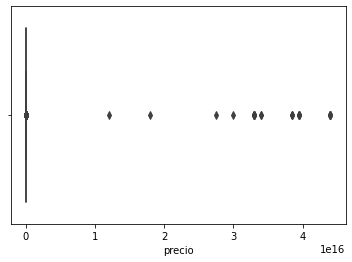

In [39]:
sns.boxplot(x = 'precio', data = dicc_df['precios_semanas_20200419_20200426']);

En la gráfica se puede ver que el valor de los outliers está en el orden de de 1e^16 lo cual no tiene sentido tratandose de precios de productos de mercado. Por lo tanto, deben ser eliminados.

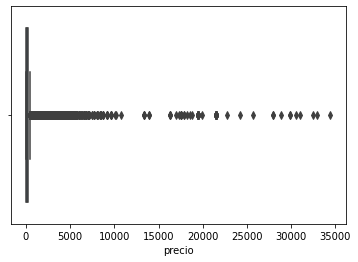

In [40]:
sns.boxplot(x = 'precio', data = dicc_df['precios_semana_20200413']);

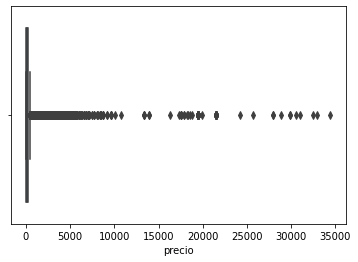

In [41]:
sns.boxplot(x = 'precio', data = dicc_df['precios_semana_20200503']);

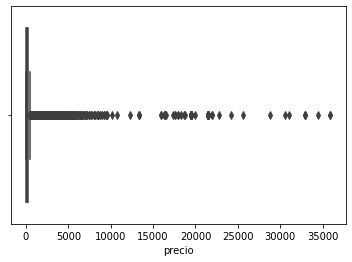

In [42]:
sns.boxplot(x = 'precio', data = dicc_df['precios_semana_20200518']);

Los otros casos presentan outliers, pero se puede notar que son valores representativos y no se deben a un error de carga.

- Corrección

Si bien he determinado algunos elementos a eliminar, lo correcto en este caso, ya que la documentación no detalla que tipo de productos abarca el relevamiento, sería contactarse con el cliente y consultar sobre valores máximos y mínimos aproximados del mercado en cuestión a fin de saber que filtro aplicar a los datos. Para avanzar en este caso decido poner un límite de 1.000.000. 

In [43]:
for key in dicc_df.keys():
    if 'precios_semana' in key:
        for col in dicc_df[key].columns:
            if 'precio' in col:
                dicc_df[key][col] = dicc_df[key][col][dicc_df[key][col] <= 1000000]

- Verificación

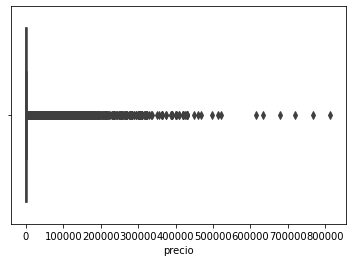

In [44]:
sns.boxplot(x = 'precio', data = dicc_df['precios_semanas_20200419_20200426']);

##### # Coordenadas

- Detección

In [52]:
mapa = folium.Map(location=(-38.276072, -64.946496), zoom_start=3)

In [53]:
coordenadas = dicc_df['sucursal'][['lat', 'lng']]

In [54]:
for e in range(0,coordenadas.shape[0]):
    folium.Circle(
        location=[coordenadas.iloc[e]['lat'], coordenadas.iloc[e]['lng']],
        radius=3,
        color='red').add_to(mapa)

mapa

Por medio del mapa compruebo que todos los valores pertenecen a coordenadas de puntos en Argentina, por lo que los outliers encontrados no se deben a errores.

---

### sucursal_id | producto_id

Controlar que los id sean únicos, debido a que serán primary keys en la base de datos

- Detección

In [48]:
# Cantidad de registros duplicados por df
dicc_df['sucursal'][dicc_df['sucursal']['sucursal_id'].duplicated() == True]

,sucursal_id,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo


In [49]:
# Cantidad de registros duplicados por df
dicc_df['producto'][dicc_df['producto']['producto_id'].duplicated() == True]

,producto_id,marca,nombre,presentacion
3483,2301594000000,SIN MARCA,Asado Con Vacio Con Matambre Complemento x 1 Kg,1.0 kg
3493,2301612000005,SIN MARCA,Tapa de Asado Complemento 1 Kg,1.0 kg
3496,2301627000007,SIN MARCA,Palito del Oceano 1 Kg,1.0 kg
3564,2302020000007,SADIA,Picada Especial 1 Kg,1.0 kg
3587,2302055000003,FAMILIA GRION,Bondiola Envasada al Vacio Feteado Famialia Gr...,1.0 kg
...,...,...,...,...
71739,0000000746007,MILKAUT,Queso Barra Milkaut 1 Kg,1.0 kg
71747,0000000829960,SIN MARCA,Asado Promo en Bandeja 1 Kg,1.0 kg
71787,0000000914796,SIN MARCA,Berenjena Negra 1 Kg,1.0 kg
71804,0000000927642,SIN MARCA,Hinojo 1 Kg,1.0 un


- Correción

In [50]:
dicc_df['producto'] = dicc_df['producto'].drop_duplicates(dicc_df['producto'].columns[dicc_df['producto'].columns.isin(['producto_id'])],
                        keep='first')

- Verificación

In [51]:
# Cantidad de registros duplicados por df
dicc_df['producto'][dicc_df['producto']['producto_id'].duplicated() == True]

,producto_id,marca,nombre,presentacion
